# Demonstration

This notebook demostrates possible usages of the code and displays some interesting phenomenology of the memory.

In [1]:
import gwmemory

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = "Computer Modern Roman"
mpl.rcParams["font.size"] = 20
mpl.rcParams["text.usetex"] = True
mpl.rcParams["grid.alpha"] = 0

## Importance of Higher-Order Modes

This figure demonstrates the importance of including higher-order oscillatory modes in the evaluation of the memory.

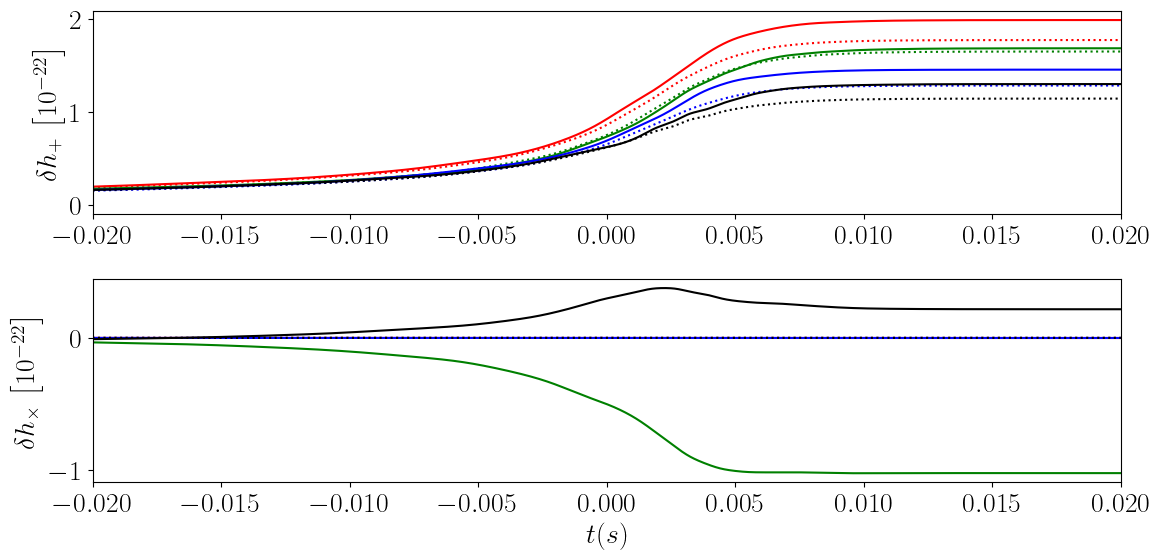

In [3]:
fig = plt.figure(figsize=(12, 6))

qs = [1.0, 2.0]
S1s = [[0.0, 0.0, 0.0], [0.8, 0.0, 0.0]]
S2s = [[0.0, 0.0, 0.0], [0.0, 0.8, 0.0]]

colours = ["r", "b", "g", "k"]

times = np.linspace(-0.08, 0.02, 10001)

labels = ["Equal-mass, non-spinning"]

ax = [fig.add_subplot(2, 1, 1), fig.add_subplot(2, 1, 2)]

parameters = dict(
    total_mass=60, distance=400, model="NRSur7dq2", inc=np.pi / 2, phase=0, times=times
)

for ii, q in enumerate(qs):
    parameters["q"] = q
    for jj, (S1, S2) in enumerate(zip(S1s, S2s)):
        colour = colours[ii + jj * 2]

        parameters["spin_1"] = S1
        parameters["spin_2"] = S2

        h_mem, times = gwmemory.time_domain_memory(**parameters)

        ax[0].plot(times, h_mem["plus"] * 1e22, linestyle="-", color=colour)
        ax[1].plot(times, h_mem["cross"] * 1e22, linestyle="-", color=colour)

        h_mem, times = gwmemory.time_domain_memory(
            **parameters, Lmax=2, modes=[(2, 2), (2, -2)]
        )

        ax[0].plot(times, h_mem["plus"] * 1e22, linestyle=":", color=colour)
        ax[1].plot(times, h_mem["cross"] * 1e22, linestyle=":", color=colour)

plt.xlabel("$t (s)$")
ax[0].set_ylabel("$\delta h_{+} \, \left[10^{-22}\\right]$")
ax[1].set_ylabel("$\delta h_{\\times} \, \left[10^{-22}\\right]$")

ax[0].set_xlim(-0.02, 0.02)
ax[1].set_xlim(-0.02, 0.02)

plt.tight_layout()
plt.show()
plt.close()

## Oscillatory Mode Dependance

This figure demonstrates the impact of the different oscillatory modes on the memory.

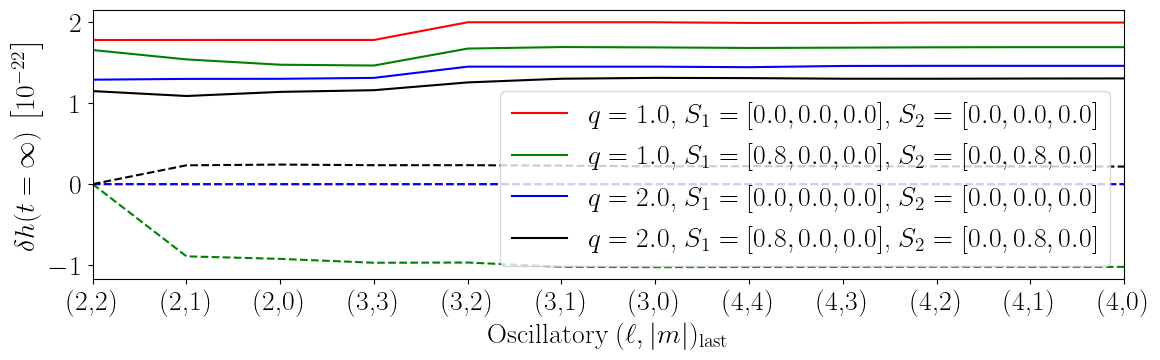

In [4]:
qs = [1.0, 2.0]
S1s = [[0.0, 0.0, 0.0], [0.8, 0.0, 0.0]]
S2s = [[0.0, 0.0, 0.0], [0.0, 0.8, 0.0]]

colours = ["r", "b", "g", "k"]

mems_plus = {}
mems_cross = {}

times = np.linspace(-0.08, 0.02, 10001)

parameters = dict(total_mass=60, distance=400, times=times)

for ii, q in enumerate(qs):
    parameters["q"] = q
    for jj, (S1, S2) in enumerate(zip(S1s, S2s)):
        parameters["spin_1"] = S1
        parameters["spin_2"] = S2

        surr = gwmemory.waveforms.Surrogate(**parameters)

        hmem = {}

        modes = []
        for l in range(2, 5):
            for m in np.flipud(range(0, l + 1)):
                modes += list(set([(l, m), (l, -m)]))
                hmem[f"{l}{m}"], times = surr.time_domain_memory(
                    inc=np.pi / 2, phase=0, modes=modes
                )

        max_h_mem_plus = []
        max_h_mem_cross = []
        keys = []
        for l in range(2, 5):
            for m in np.flipud(range(0, l + 1)):
                keys.append(f"{l}{m}")
                max_h_mem_plus.append(hmem[f"{l}{m}"]["plus"][-1])
                max_h_mem_cross.append(hmem[f"{l}{m}"]["cross"][-1])

        mems_plus[f"{q}{S1}{S2}"] = np.array(max_h_mem_plus)
        mems_cross[f"{q}{S1}{S2}"] = np.array(max_h_mem_cross)

colours = ["r", "b", "g", "k"]

spin_keys = [f"{S1}{S2}" for S1, S2 in zip(S1s, S2s)]

fig = plt.figure(figsize=(12, 4))

for ii, q in enumerate(qs):
    for jj, (S1, S2) in enumerate(zip(S1s, S2s)):

        key = f"{q}{S1}{S2}"
        max_h_mems_plus = mems_plus[key]
        max_h_mems_cross = mems_cross[key]

        plt.plot(
            range(len(max_h_mems_plus)),
            max_h_mems_plus * 1e22,
            color=colours[ii + jj * 2],
            linestyle="-",
            label=f"$q={q}$, $S_1={S1}$, $S_2={S2}$",
        )
        plt.plot(
            range(len(max_h_mems_cross)),
            max_h_mems_cross * 1e22,
            color=colours[ii + jj * 2],
            linestyle="--",
        )

plt.xticks(range(len(max_h_mems_plus)))
keys = [f"({ell},{delta_m})" for ell, delta_m in keys]
ax = plt.gca()
ax.set_xticklabels(keys)
plt.xlim(0, len(max_h_mems_plus) - 1)
ax.grid(axis="both")

plt.xlabel("Oscillatory $(\ell, |m|)_{\mathrm{last}}$")
plt.ylabel("$\delta h(t=\infty) \, \left[10^{-22}\\right]$")
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()
plt.close()

## Memory Mode Dependance

This figure shows the spin-weighted spherical harmonic decomposition of the memory waveform.

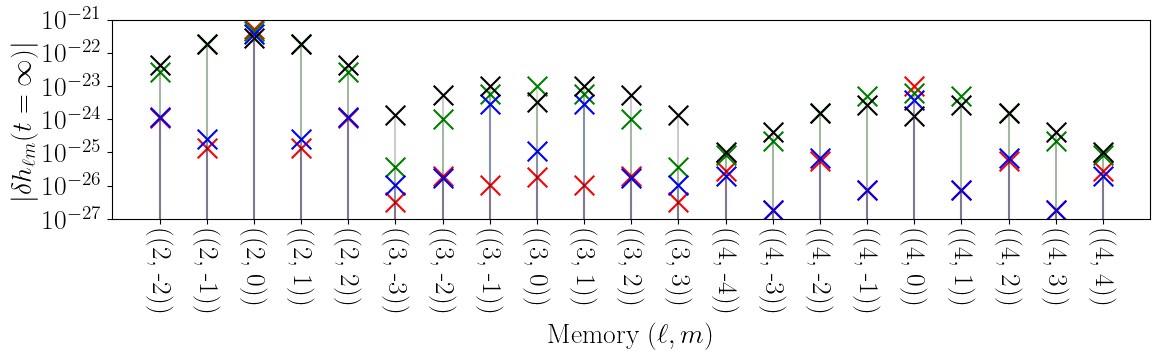

In [5]:
fig = plt.figure(figsize=(12, 4))

qs = [1.0, 2.0]
S1s = [[0.0, 0.0, 0.0], [0.8, 0.0, 0.0]]
S2s = [[0.0, 0.0, 0.0], [0.0, 0.8, 0.0]]

colours = ["r", "b", "g", "k"]

times = np.linspace(-0.08, 0.02, 10001)

parameters = dict(total_mass=60, distance=400, times=times, model="NRSur7dq2")

for ii, q in enumerate(qs):
    parameters["q"] = q
    for jj, (S1, S2) in enumerate(zip(S1s, S2s)):
        parameters["spin_1"] = S1
        parameters["spin_2"] = S2

        h_mem, times = gwmemory.time_domain_memory(**parameters)

        colour = colours[ii + jj * 2]

        for ell, delta_m in h_mem:
            if ell <= 4:
                if ell == 2 and delta_m == 0:
                    plt.scatter(
                        ell**2 + delta_m + ell,
                        abs(h_mem[(ell, delta_m)][-1]),
                        marker="x",
                        s=200,
                        color=colour,
                        label=f"$q={q}$, $S_1={S1}$, $S_2={S2}$",
                    )
                else:
                    plt.scatter(
                        ell**2 + delta_m + ell,
                        abs(h_mem[(ell, delta_m)][-1]),
                        marker="x",
                        s=200,
                        color=colour,
                    )
                plt.plot(
                    [ell**2 + delta_m + ell, ell**2 + delta_m + ell],
                    [0, abs(h_mem[(ell, delta_m)][-1])],
                    color=colour,
                    alpha=0.2,
                )

plt.xlim(3, 5**2)
plt.xticks(range(4, 5**2, 1), rotation=270)
keys = [f"({ell, delta_m})" for ell, delta_m in gwmemory.harmonics.lmax_modes(4)]
ax = plt.gca()
ax.set_xticklabels(keys)
plt.xlabel("Memory $(\ell, m)$")

plt.ylim(1e-27, 1e-21)
plt.yscale("log")
plt.ylabel("$|\delta h_{\ell m}(t=\infty)|$")

ax = plt.gca()
ax.set_yticks(np.logspace(-27, -21, 7))
ax.grid(axis="y")

plt.tight_layout()
plt.show()
plt.close()

## Orientation Dependance

Next we plot the orientation dependance of the + and x polarized memory as a function of source inclination (zenith) and orbital phase (azimuth).

*NOTE: this plot requires [`Basemap`](https://github.com/matplotlib/basemap) for the projection.*

Install with
```console
$ conda install -c conda-forge basemap
```

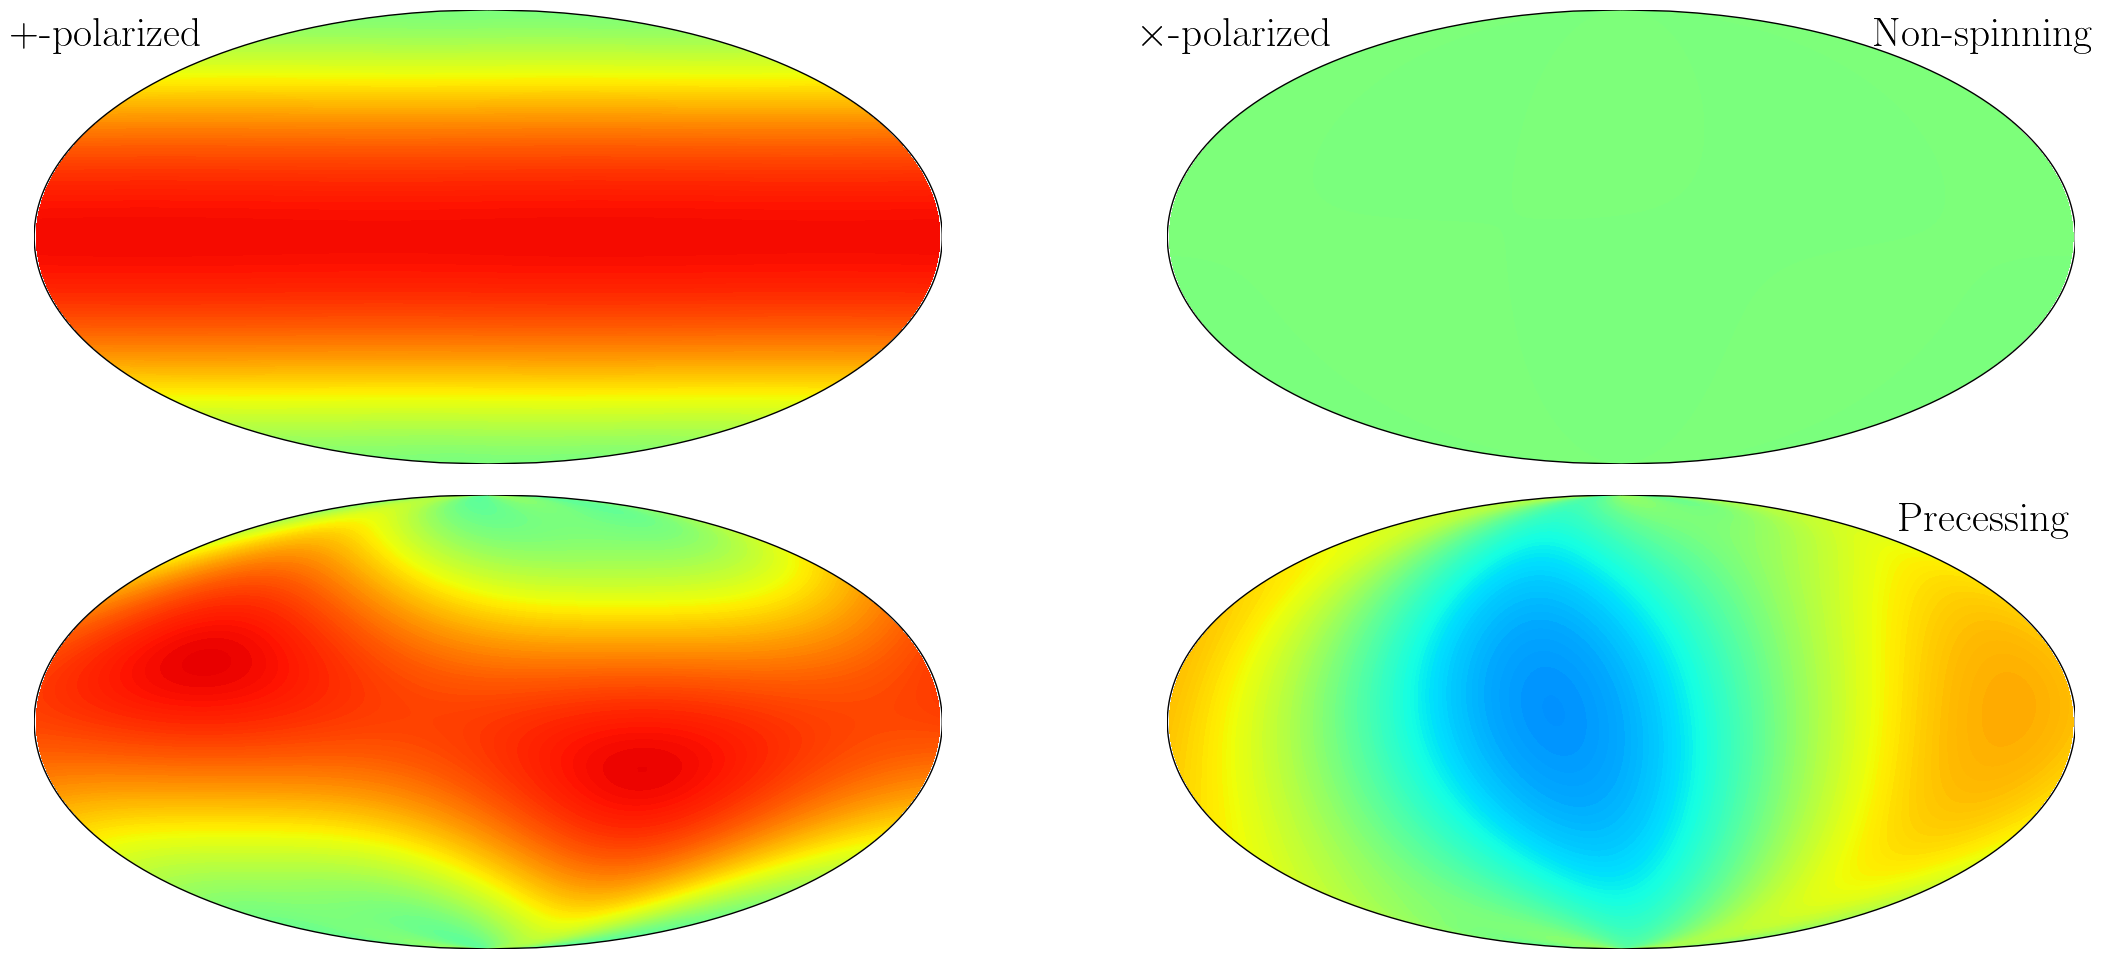

In [6]:
from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize=(24, 10))

qs = [1.0]
S1s = [[0.0, 0.0, 0.0], [0.8, 0.0, 0.0]]
S2s = [[0.0, 0.0, 0.0], [0.0, 0.8, 0.0]]

labels = ["Non-spinning", "Precessing"]

parameters = dict(total_mass=60, distance=400, times=times, model="NRSur7dq2")

for ii, q in enumerate(qs):
    parameters["q"] = q
    for jj, (S1, S2) in enumerate(zip(S1s, S2s)):
        parameters["spin_1"] = S1
        parameters["spin_2"] = S2

        h_mem_lm, times = gwmemory.time_domain_memory(**parameters)

        inc_array = np.linspace(0, np.pi, 200) - np.pi / 2
        pol_array = np.linspace(0, 2 * np.pi, 200) - np.pi
        pols, incs = np.meshgrid(pol_array, inc_array)
        pols_deg = pols * 180 / np.pi
        incs_deg = incs * 180 / np.pi
        y_lm = {
            (ell, m): gwmemory.harmonics.sYlm(-2, ell, m, incs + np.pi / 2, pols)
            for ell, m in h_mem_lm.keys()
        }

        orientation_map = np.sum(
            [y_lm[key] * h_mem_lm[key][-1] for key in y_lm], axis=0
        )

        ax = plt.subplot(2, 2, ii * 4 + jj * 2 + 1)
        m = Basemap(projection="moll", lon_0=-180, resolution="c")
        m.contourf(
            pols_deg,
            incs_deg,
            orientation_map.real,
            100,
            cmap=plt.cm.jet,
            latlon=True,
            levels=np.linspace(-2.5e-22, 2.5e-22, 201),
        )

        if jj == 0:
            ax.annotate(
                text="$+$-polarized",
                xy=(0.08, 0.92),
                xycoords="axes fraction",
                fontsize=30,
                horizontalalignment="center",
            )

        ax = plt.subplot(2, 2, ii * 4 + jj * 2 + 2)
        m = Basemap(projection="moll", lon_0=-180, resolution="c")
        m.contourf(
            pols_deg,
            incs_deg,
            orientation_map.imag,
            100,
            cmap=plt.cm.jet,
            latlon=True,
            levels=np.linspace(-2.5e-22, 2.5e-22, 201),
        )
        if jj == 0:
            ax.annotate(
                text="$\\times$-polarized",
                xy=(0.08, 0.92),
                xycoords="axes fraction",
                fontsize=30,
                horizontalalignment="center",
            )
        ax.annotate(
            text=labels[jj],
            xy=(0.9, 0.92),
            xycoords="axes fraction",
            fontsize=30,
            horizontalalignment="center",
        )

plt.tight_layout()
plt.show()
plt.close()

## Memory of Memory

This figure shows the importance of each order of the waveform.

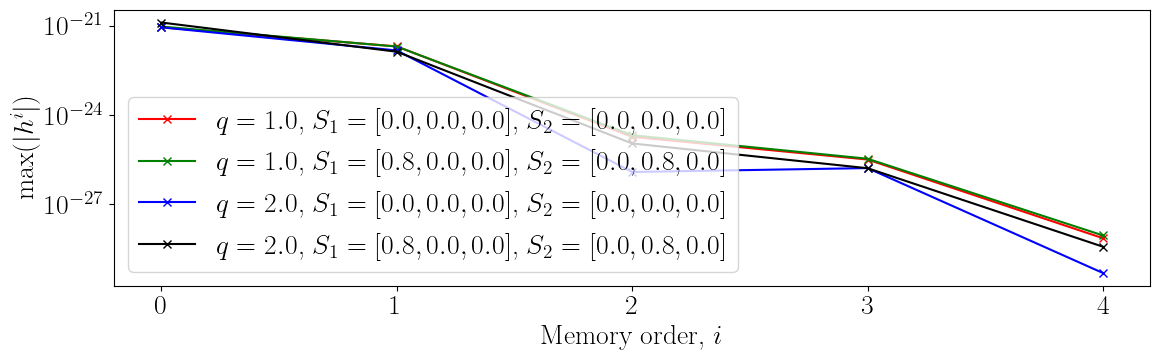

In [7]:
fig = plt.figure(figsize=(12, 4))

qs = [1.0, 2.0]
S1s = [[0.0, 0.0, 0.0], [0.8, 0.0, 0.0]]
S2s = [[0.0, 0.0, 0.0], [0.0, 0.8, 0.0]]

colours = ["r", "b", "g", "k"]

times = np.linspace(-0.08, 0.02, 10001)

parameters = dict(total_mass=60, distance=400, times=times)

for ii, q in enumerate(qs):
    parameters["q"] = q
    for jj, (S1, S2) in enumerate(zip(S1s, S2s)):
        parameters["spin_1"] = S1
        parameters["spin_2"] = S2

        surr = gwmemory.waveforms.Surrogate(**parameters)
        osc = gwmemory.utils.combine_modes(surr.h_lm, np.pi / 2, 0)
        modes = gwmemory.harmonics.lmax_modes(4)
        old_h_mem = np.array(0 * (1 + 1j))
        delta_h = [max(abs(osc["plus"] - 1j * osc["cross"]))]

        for kk in range(1, 5):
            h_mem, times = surr.time_domain_memory(np.pi / 2, 0)
            delta_h.append(h_mem["plus"][-1] - 1j * h_mem["cross"][-1] - old_h_mem)
            old_h_mem = h_mem["plus"][-1] - 1j * h_mem["cross"][-1]
            h_mem_lm, times = surr.time_domain_memory()
            surr = gwmemory.waveforms.Surrogate(**parameters)
            for key in h_mem_lm:
                if key[0] <= 4:
                    surr.h_lm[key] += h_mem_lm[key]

        colour = colours[ii + jj * 2]

        plt.semilogy(
            range(5),
            np.abs(delta_h),
            marker="x",
            label=f"$q={q}$, $S_1={S1}$, $S_2={S2}$",
            color=colour,
        )
        plt.xlabel("Memory order, $i$")
        plt.ylabel("$\max(|h^i|)$")

plt.xticks(range(5))
plt.legend(loc="lower left")

ax = plt.gca()
ax.grid(True, axis="y")

plt.tight_layout()
plt.show()
plt.close()

## Other Examples

Below are some additional examples of using the code.

## Compare Waveform models

Compare the memory predicted using the available waveforms.

*FIXME: add references*

/usr/share/miniconda/envs/__setup_conda/lib/python3.11/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


/usr/share/miniconda/envs/__setup_conda/lib/python3.11/site-packages/gwmemory/waveforms/mwm.py:132: RuntimeWarning: invalid value encountered in power
  rr = rm * (1 - TT / trr) ** (1 / 4)
/usr/share/miniconda/envs/__setup_conda/lib/python3.11/site-packages/gwmemory/waveforms/mwm.py:150: ComplexWarning: Casting complex values to real discards the imaginary part
  h_MWM[post_merger] = 8 * np.pi * MM / rm + alt_sum_terms / (eta * MM)


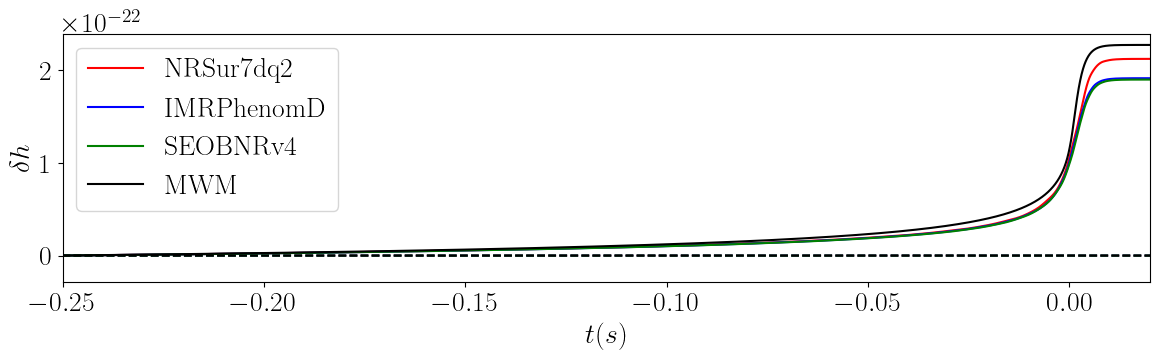

In [8]:
fig = plt.figure(figsize=(12, 4))

q = 1.0
S1 = [0.0, 0.0, 0.0]
S2 = [0.0, 0.0, 0.0]

colours = ["r", "b", "g", "k"]

parameters = dict(
    q=1, spin_1=S1, spin_2=S2, total_mass=60, distance=400, inc=np.pi / 2, phase=0.0
)


for ii, model in enumerate(["NRSur7dq2", "IMRPhenomD", "SEOBNRv4", "MWM"]):
    h_mem, times = gwmemory.time_domain_memory(**parameters, model=model)

    plt.plot(
        times,
        h_mem["plus"] - h_mem["plus"][np.argmin(abs(times + 0.25))],
        linestyle="-",
        color=colours[ii],
        label=model,
    )
    plt.plot(
        times,
        h_mem["cross"] - h_mem["cross"][np.argmin(abs(times + 0.25))],
        linestyle="--",
        color=colours[ii],
    )

plt.xlabel("$t (s)$")
plt.ylabel("$\delta h$")
plt.legend(loc="upper left", fontsize=20)

plt.xlim(-0.25, 0.02)

plt.tight_layout()
plt.show()
plt.close()

## Oscillatory and Memory Waveform

In order to generate the memory we necessarily generate the time-domain oscillatory waveform.

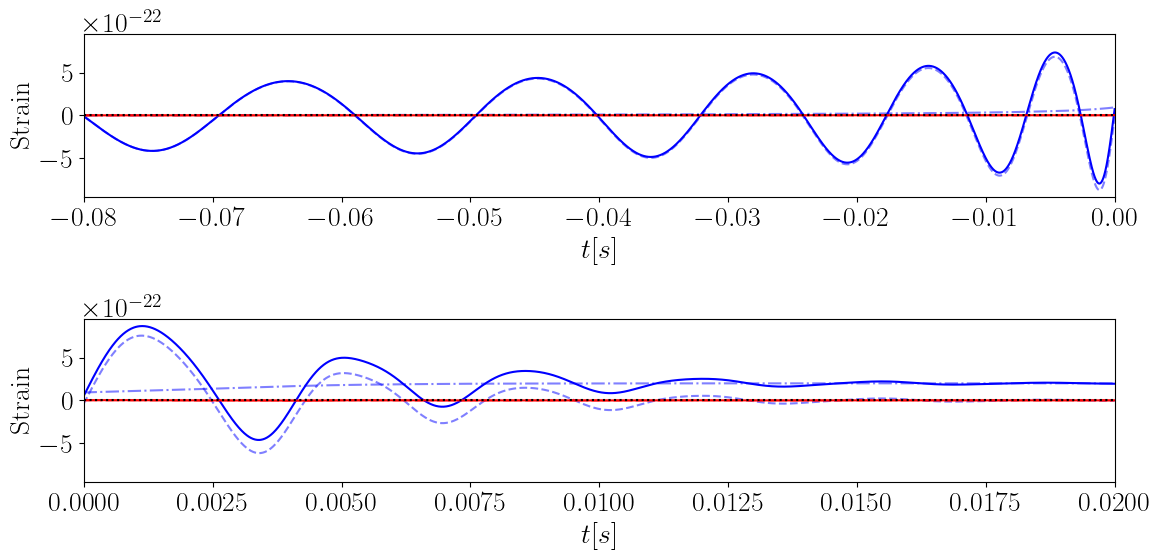

In [9]:
q = 1.0
S1 = [0.0, 0.0, 0.0]
S2 = [0.0, 0.0, 0.0]

times = np.linspace(-0.08, 0.02, 10001)
surr = gwmemory.waveforms.Surrogate(
    q=q, spin_1=S1, spin_2=S2, total_mass=60, distance=400, times=times
)

inc = np.pi / 2
pol = 0

oscillatory, times = surr.time_domain_oscillatory(inc=inc, phase=pol)
memory, times = surr.time_domain_memory(inc=inc, phase=pol)

fig = plt.figure(figsize=(12, 6))
fig.add_subplot(2, 1, 1)
plt.plot(times, oscillatory["plus"], linestyle="--", color="b", alpha=0.5)
plt.plot(times, oscillatory["cross"], linestyle="--", color="r", alpha=0.5)
plt.plot(times, memory["plus"], linestyle="-.", color="b", alpha=0.5)
plt.plot(times, memory["cross"], linestyle="-.", color="r", alpha=0.5)
plt.plot(times, oscillatory["plus"] + memory["plus"], color="b")
plt.plot(times, oscillatory["cross"] + memory["cross"], color="r")
plt.xlabel("$t [s]$")
plt.ylabel("Strain")
plt.axhline(0, linestyle=":", color="k")
plt.xlim(-0.08, 0.0)

fig.add_subplot(2, 1, 2)
plt.plot(times, oscillatory["plus"], linestyle="--", color="b", alpha=0.5)
plt.plot(times, oscillatory["cross"], linestyle="--", color="r", alpha=0.5)
plt.plot(times, memory["plus"], linestyle="-.", color="b", alpha=0.5)
plt.plot(times, memory["cross"], linestyle="-.", color="r", alpha=0.5)
plt.plot(times, oscillatory["plus"] + memory["plus"], color="b")
plt.plot(times, oscillatory["cross"] + memory["cross"], color="r")
plt.xlabel("$t [s]$")
plt.ylabel("Strain")
plt.axhline(0, linestyle=":", color="k")
plt.xlim(-0.0, 0.02)

plt.tight_layout()
plt.show()
plt.close()

## Frequency Domain Memory


For graviational-wave parameter estimation we will require frequency domain waveforms. This is currently implemented by performing a fast fourier transform on the time domain waveform.

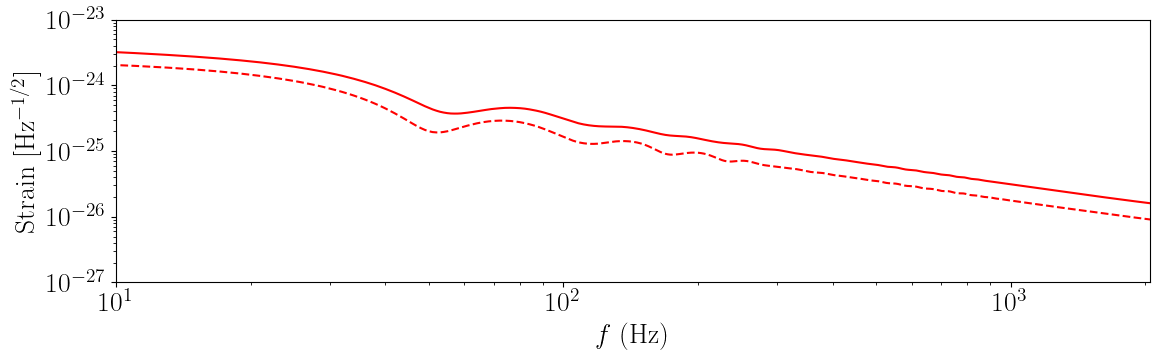

In [10]:
fig = plt.figure(figsize=(12, 4))

q = 1.0
S1 = [0, 0.8, 0]
S2 = [0.8, 0, 0]

times = np.linspace(-0.98, 0.02, 10000)

colours = ["r", "b", "g", "k"]

h_mem, frequencies = gwmemory.frequency_domain_memory(
    q=q,
    spin_1=S1,
    spin_2=S2,
    total_mass=60.0,
    distance=400.0,
    model="NRSur7dq2",
    inc=np.pi / 2,
    phase=0.0,
    times=times,
)

plt.loglog(frequencies, abs(h_mem["plus"]), linestyle="-", color="r", label=model)
plt.loglog(frequencies, abs(h_mem["cross"]), linestyle="--", color="r")

plt.xlabel("$f$ (Hz)")
plt.ylabel("Strain [Hz$^{-1/2}$]")

plt.xlim(10, 2048)
plt.ylim(1e-27, 1e-23)

ax = plt.gca()
ax.grid(True, axis="y")

plt.tight_layout()
plt.show()
plt.close()